In [1]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import LeaveOneOut
import ssl
from scipy.stats import norm

# necessary to read data from website
ssl._create_default_https_context = ssl._create_unverified_context

# load data
df = pd.read_table('https://www.stat.cmu.edu/~larry/all-of-nonpar/=data/galaxy.dat',
                   header=None, delimiter='    ', engine='python')

### Introduction

We have data from the Sloan Digital Sky Survey (SDSS). As described on the SDSS website www.sdss.org:

*Simply put, the Sloan Digital Sky Survey is the most ambitious astronomical survey project ever undertaken.*

*The survey will map  in detail one-quarter of the entire sky, determining the positions and absolute brightnesses*

*of more than 100 million celestial objects. It will also measure the distances to more than a million galaxies and quasars.*

Each data point $X_i$ is a redshift, essentially the distance from us to a galaxy.
The data lie on a “pencil beam” which means that the sample lies in a narrow
tube starting at the earth and pointing out into space; see Figure 4.2. The
full dataset is three-dimensional. We have extracted data along this pencil
beam to make it one-dimensional. Our goal is to understand the distribution
of galaxies. In particular, astronomers are interested in finding clusters of
galaxies. Because the speed of light is finite, when we look at galaxies that are
farther away we are seeing further back in time. By looking at how galaxies
cluster as a function of redshift, we are seeing how galaxy clustering evolved
over time.
We regard the redshifts $X_1, \ldots, X_n$ as a sample from a distribution $F$ with
density $f = F'$, that is,
$$X_1, \ldots, X_n \thicksim f.$$
One way to find galaxy clusters is to look for peaks in the density $f$.

A histogram is a simple method for estimating the density $f$. So in this example, we construct a histogram and confidence intervals for the histogram, in order to asses the formation of galaxy clusters.

To construct a histogram, we first define the bins $B_j = [jh, (j+1)h)$. So the density asigned to $x$ is given by
$$\hat{f}_{nh} (x) = \frac{1}{nh} \sum_{i=1}^{n} \mathbf{1}\{X_i \in B_j\},$$
where $\mathbf{1}\{\cdot\}$ is the indicator function. It is know that under some conditions, the histogram is a consistent estimator for $f$. But, first we have to find an appropiate binwidth $h$ for the histogram, so we look for a value $h$ that minimizes the integrated loss
$$J(h) = \int \left( \hat{f}_n(x)\right)^2  dx - \int  2 \hat{f}_n(x) f(x) dx.$$
In particular, we use the cross vaidation leave one out to estimate the integrated loss
$$\hat{J}(h) = \int \left( \hat{f}_n (x) \right)^2 dx - \frac{2}{n} \sum_{i=1}^{n} \hat{f}_{(-i)}(X_i),$$
where $\hat{f}_{(-i)}$ is the estimator of the density under leaving out the $i$-th observation from the dataset. We refer to $\hat{J}(h)$ as the cross validated score or estimated risk. Fortunately the next identity holds:
$$\hat{J}(h) = \frac{2}{h(n-1)} - \frac{n+1}{h(n-1)} \sum_{j=1}^{m} \hat{p}_j^2.$$
Which we will use to find a good $h$ to construct the histogram.

In [2]:
# extract redshift data
x = df[2].to_numpy()
x = x[x <= 0.2]
n = x.shape[0]

In [3]:
def cv_hist(x):
    """
    
    """
    
    # Checks! 
    n = x.shape[0]
    a = x.min()
    b = x.max()
    k = 100
    nbins = np.round(np.arange(1, n, k/20))
    h     = (b-a)/nbins
    risk  = np.zeros(nbins.shape[0])

    for i in range(nbins.shape[0]):
        br = np.linspace(a, b, int(nbins[i]+1))
        N  = np.histogram(x, bins=br)[0]
        risk[i] =  sum(N**2)/((n**2)*h[i]) - (2/(h[i]*n*(n-1)))*sum(N*(N-1))
    
    hbest = h[risk == min(risk)]
    # in case of tie take first (smallest) one
    hbest = hbest[0] 
    # optimal number of bins
    mbest = int((b-a)/hbest)  

    return(risk, nbins, h, mbest)

In [4]:
risk, nbins, h, mbest = cv_hist(x)

Text(0.5, 1.0, 'Cross Validated Score')

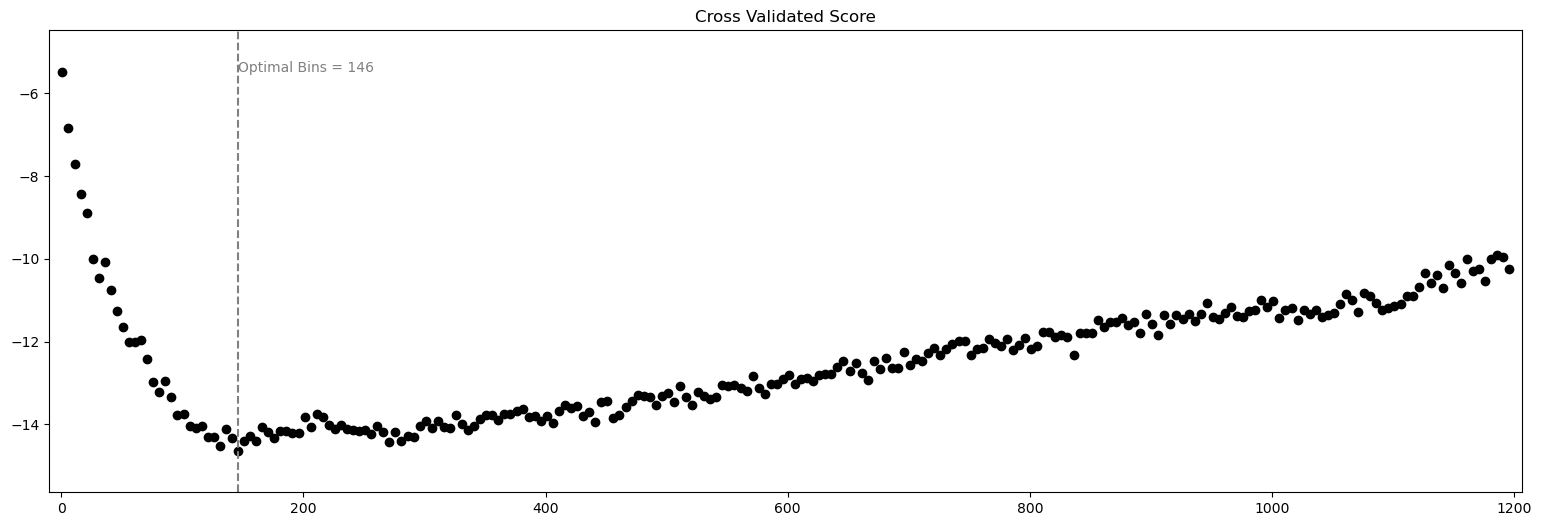

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(19,6))

plt.plot(nbins, risk, 'ko')
plt.vlines(mbest, risk.min()-1, risk.max()+1,
           linestyle='--', color='grey')
plt.xlim(-10,nbins.max()+10)
plt.ylim(risk.min()-1, risk.max()+1)
plt.text(mbest, y = risk.max(), s='Optimal Bins = ' + str(mbest), color='grey')
plt.title('Cross Validated Score')

Text(0.5, 1.0, 'Histogram with Optimal Number of Bins.')

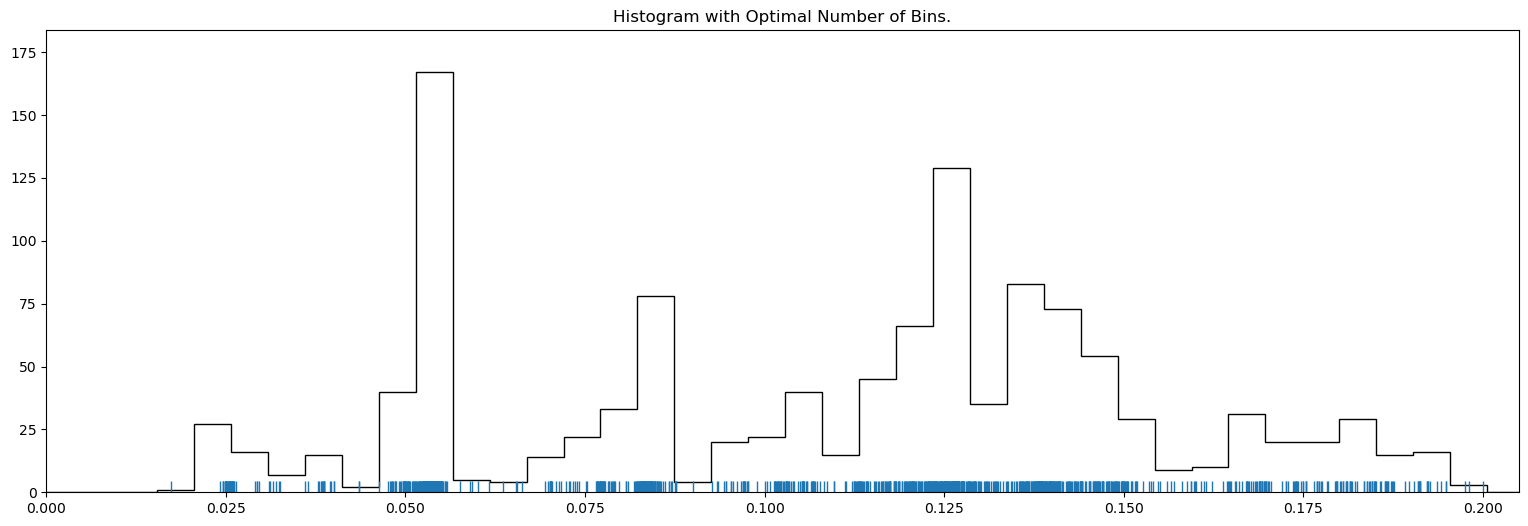

In [6]:
counts_, bins_ = np.histogram(x, range=(0, 0.36), bins=70)

fig, ax = plt.subplots(1, 1, figsize=(19,6))
plt.stairs(counts_, bins_, color='k')
sns.rugplot(x)
plt.xlim(0, 0.205)
plt.title('Histogram with Optimal Number of Bins.')

Text(0.5, 1.0, 'Undersmoothed-Histogram (Very High Number of Bins).')

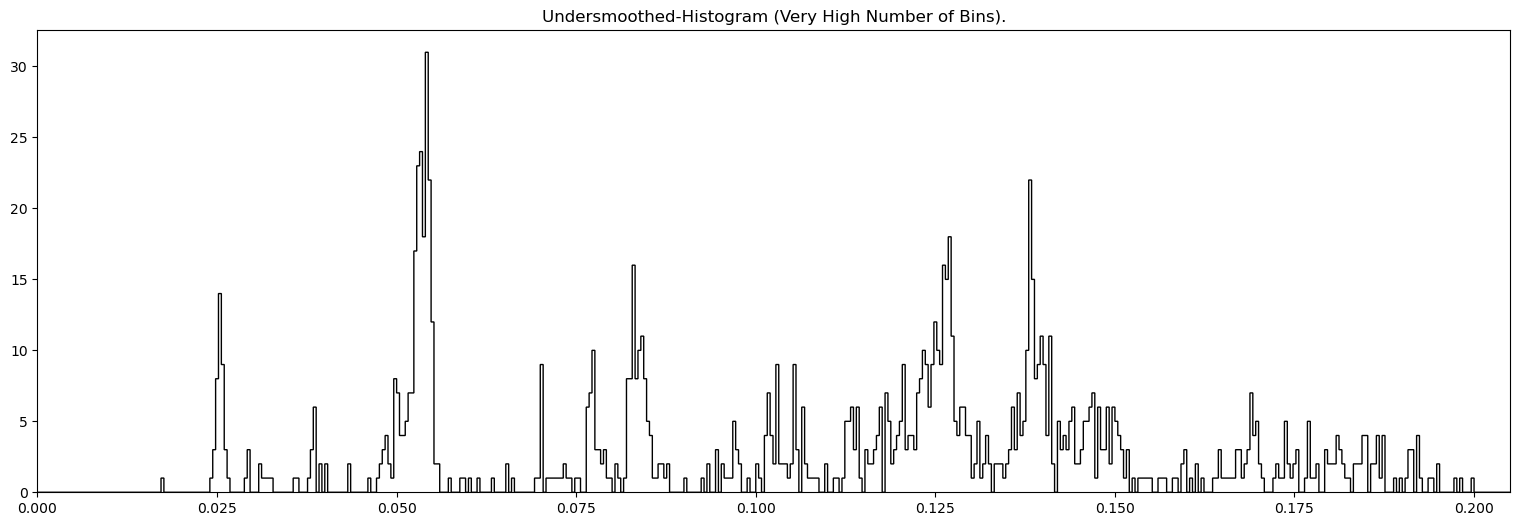

In [7]:
counts__, bins__ = np.histogram(x, range=(0, 0.36), bins=900)

fig, ax = plt.subplots(1, 1, figsize=(19,6))
plt.stairs(counts__, bins__, color='k')

plt.xlim(0, 0.205)
plt.title('Undersmoothed-Histogram (Very High Number of Bins).')

Text(0.5, 1.0, 'Oversmoothed-Histogram (Very Low Number of Bins).')

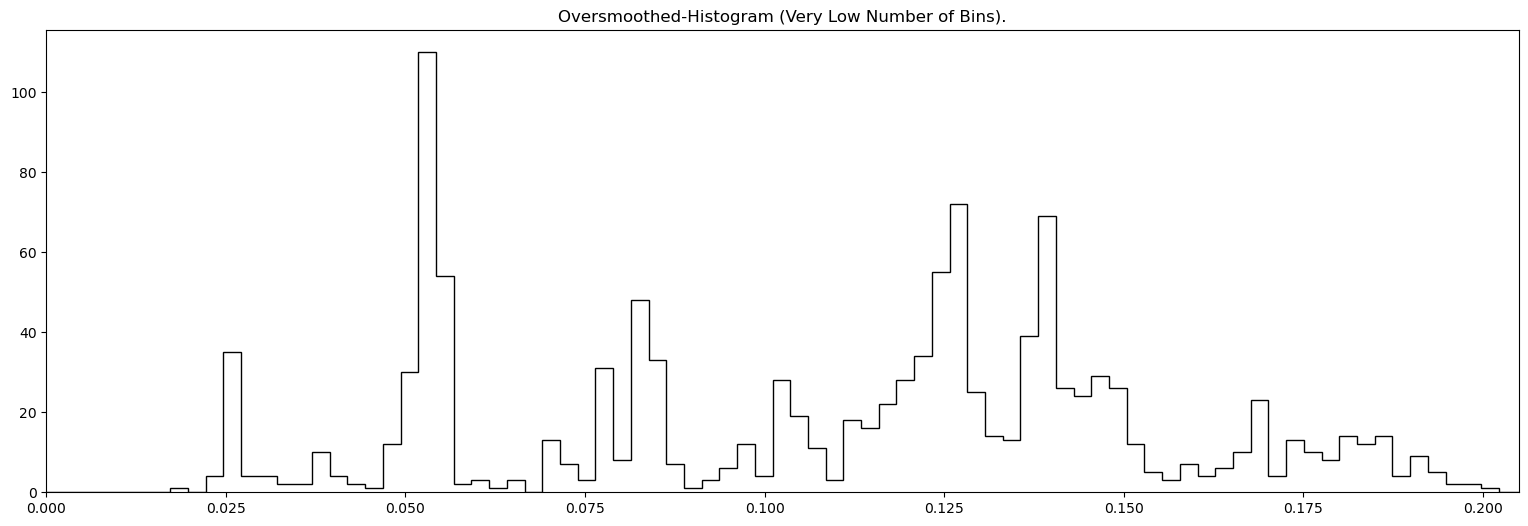

In [8]:
counts, bins = np.histogram(x, range=(0, 0.36), bins=mbest)

fig, ax = plt.subplots(1, 1, figsize=(19,6))
plt.stairs(counts, bins, color='k')

plt.xlim(0, 0.205)
plt.title('Oversmoothed-Histogram (Very Low Number of Bins).')

Now, we construct the confidence interval for the smoothed histogram by using the limits 
\begin{align*}
    l_n(x) &= \left( \max \left\{ \sqrt{\hat{f}_n (x)} - c, 0  \right\} \right)^2  \\
    u_n(x) &= \left(  \sqrt{\hat{f}_n (x)} + c \right)^2,
\end{align*}
where
$$c = \frac{z_{\alpha/(2m)}}{2} \sqrt{\frac{m}{n}}.$$
So that
$$ P \left( l(x) \leq \bar{f}_n \leq u(x)  \text{ for all } x \right) \geq 1 - \alpha,$$
where 
$$\bar{f}_n =  E\left( \hat{f}_n(x) \right) = \sum_{j=1}^{m} \frac{p_j}{h} \mathbf{1}\{ x \in B_j\}$$
is the smoothed histogram.

In [9]:
n = n
m = mbest
alpha = 0.05

c = (norm.ppf(alpha/(2*m))/2)*np.sqrt(m/n)

l_n = np.clip((np.sqrt(counts) - c)**2, 0, a_max=None)
u_n = (np.sqrt(counts) + c)**2

Text(0.5, 1.0, 'Histogram with Optimal Number of Bins and Confidence Interval with Coverage 0.95.')

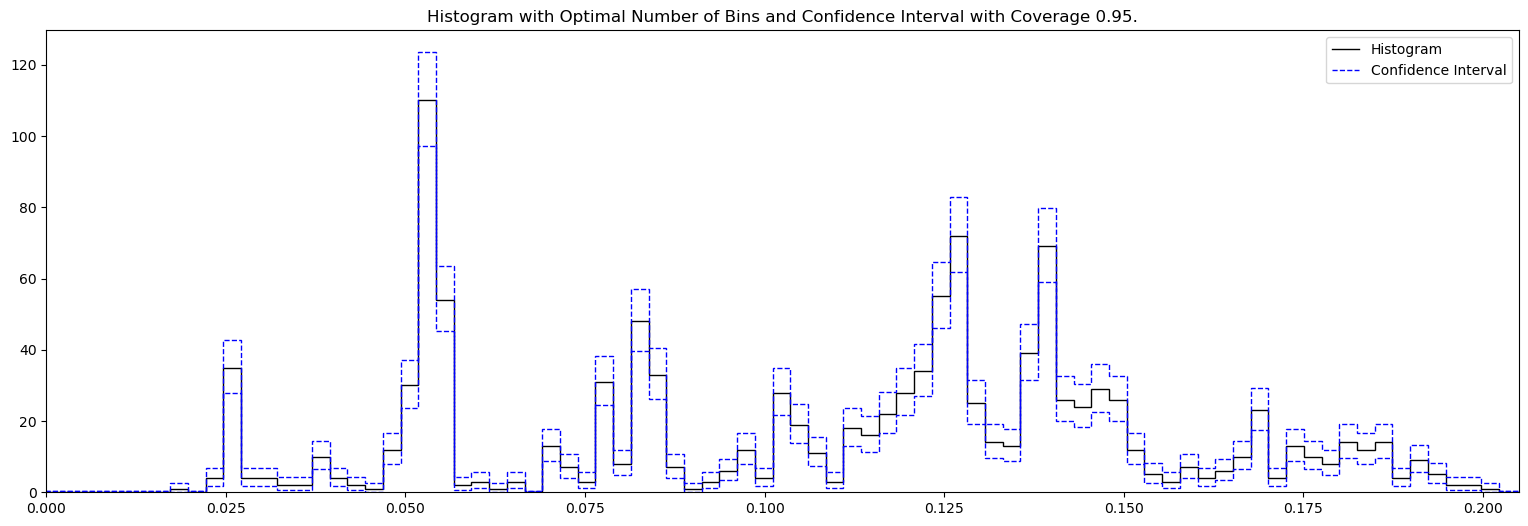

In [10]:
counts, bins = np.histogram(x, range=(0, 0.36), bins=mbest)

fig, ax = plt.subplots(1, 1, figsize=(19,6))
plt.stairs(counts, bins, color='k', label='Histogram')
plt.stairs(l_n, bins, color='b', linestyle='--', label='Confidence Interval')
plt.stairs(u_n, bins, color='b', linestyle='--')

plt.xlim(0, 0.205)
plt.legend()
plt.title('Histogram with Optimal Number of Bins and Confidence Interval with Coverage 0.95.')

### Conclusions

We can see that there are galaxy clusters from the histogram for the density of the redshifts. Also, we have seen how to construct a histogram, find an appropiate number of binds, and make a confidence interval.